## plot spatial ACC pattern of DPLE

In [2]:
import matplotlib.colors as colors
from matplotlib import cm,gridspec,rc
import matplotlib.pyplot as plt
import os
import utils
import warnings
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import corrstats
warnings.filterwarnings('ignore')

# Model Grid for region mask to remove values that are not good

In [3]:
USER = os.environ['USER']

In [4]:
path = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = f'{path}/grid-data-POP_gx1v6.nc'
grid = xr.open_dataset(filename)
region_mask = grid['REGION_MASK']
#lon = grid.coords['TLONG']
#lat = grid.coords['TLAT']

In [5]:
path = f'/glade/work/{USER}/MAPP/ETOPO'
filename = f'{path}/Etopo1_Bed_0_65N_170E_40W.nc'
bathy = xr.open_dataset(filename)
lon_e = bathy['lon']
for ii in range(len(lon_e)):
    if lon_e[ii] > 0:
        lon_e[ii] = lon_e[ii] - 360.
lat_e = bathy['lat'][300:]
depth_e = bathy['depth'][300:, :]

In [6]:
mask_bathy = (depth_e >= 0.)*1.
mask_bathy = np.ma.array(mask_bathy,mask=mask_bathy==0.)
lon_e,lat_e = np.meshgrid(lon_e,lat_e)
lon_e = np.ma.array(lon_e,mask=mask_bathy.mask)
lat_e = np.ma.array(lat_e,mask=mask_bathy.mask)

In [7]:
import matplotlib as mpl
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [8]:
new_cmapt = truncate_colormap('RdBu_r', 0.375, 1.0)
new_cmaps = truncate_colormap('PuOr_r', 0.375, 1.0)

In [9]:
lat_min = 15;   lat_max = 65
lon_min = -190; lon_max = -40
#
cmin = -.25;cmax = 1.;clev = 25.
dc = (cmax - cmin)/clev; vct = np.arange(cmin, cmax+dc, dc)
pal_normt = colors.BoundaryNorm(vct, ncolors=256, clip = False)
#
cmin = -.25;cmax = 1.;clev = 25.
dc = (cmax - cmin)/clev; vcs = np.arange(cmin, cmax+dc, dc)
pal_norms = colors.BoundaryNorm(vcs, ncolors=256, clip = False)
# text
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#csfont = {'fontname':'Times New Roman'}

## read clim BSF

In [10]:
var_name = 'BSF'
a1,a2,b1,b2 = [240,380,125,320]
datadir = f'/glade/scratch/{USER}/DPLE-results'
filename = f'{datadir}/DPLE-forcing_{var_name}_hindcast_clim.nc'
ds_hind = xr.open_dataset(filename)
nmon = ds_hind.dims['time']
bsf = ds_hind['BSF'][a1:a2,b1:b2]

## LME Shapes

In [11]:
path = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = '%s/LME_shapes.gmt' % path
file1 = open(filename,'r')
lines = file1.readlines()
#
nbox = -1
lonn = [[] for ii in range(194)]
latt = [[] for ii in range(194)]
ln = 9
for line in lines[ln:]:
    sl = line.split()
    if len(sl)==2 and sl[0] == '#':
        nbox = nbox + 1
    elif len(sl)==2 and sl[0] != '#':
        lonn[nbox-1].append(np.float(sl[0]))
        latt[nbox-1].append(np.float(sl[1]))
##
pp180 = []
for pp in range(len(lonn)):
    if len(lonn[pp])>0:
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        if len(np.where(np.abs(lon1 + 180.)<1e-4)[0])>0:
            if len(lonn[pp])<4:
                pp180.append(pp)
##
lon0 = []
lat0 = []
nn = 0
for pp in range(len(lonn)):
    if len(lonn[pp])!=0:
        nn = nn + 1
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        lat1 = np.array(latt[pp])
        lon1 = np.ma.array(lon1,mask=False)
        lat1 = np.ma.array(lat1,mask=False)
        if pp in pp180[1:]:
#        if len(np.where(np.abs(lon1+180.)<1e-4)[0]) > 0:
            #print(pp)
            aa = np.where(np.abs(lon1+180.)<1e-4)[0]
            lon1.mask[aa] = True
            lat1.mask[aa] = True
        lon0.append(lon1)
        lat0.append(lat1)

In [12]:
def mask_nan(var):
    """
    mask nan values
    """
    maskn = np.isnan(var)
    var = np.ma.array(var,mask=maskn)
    return var

In [13]:
var = 'Phi'

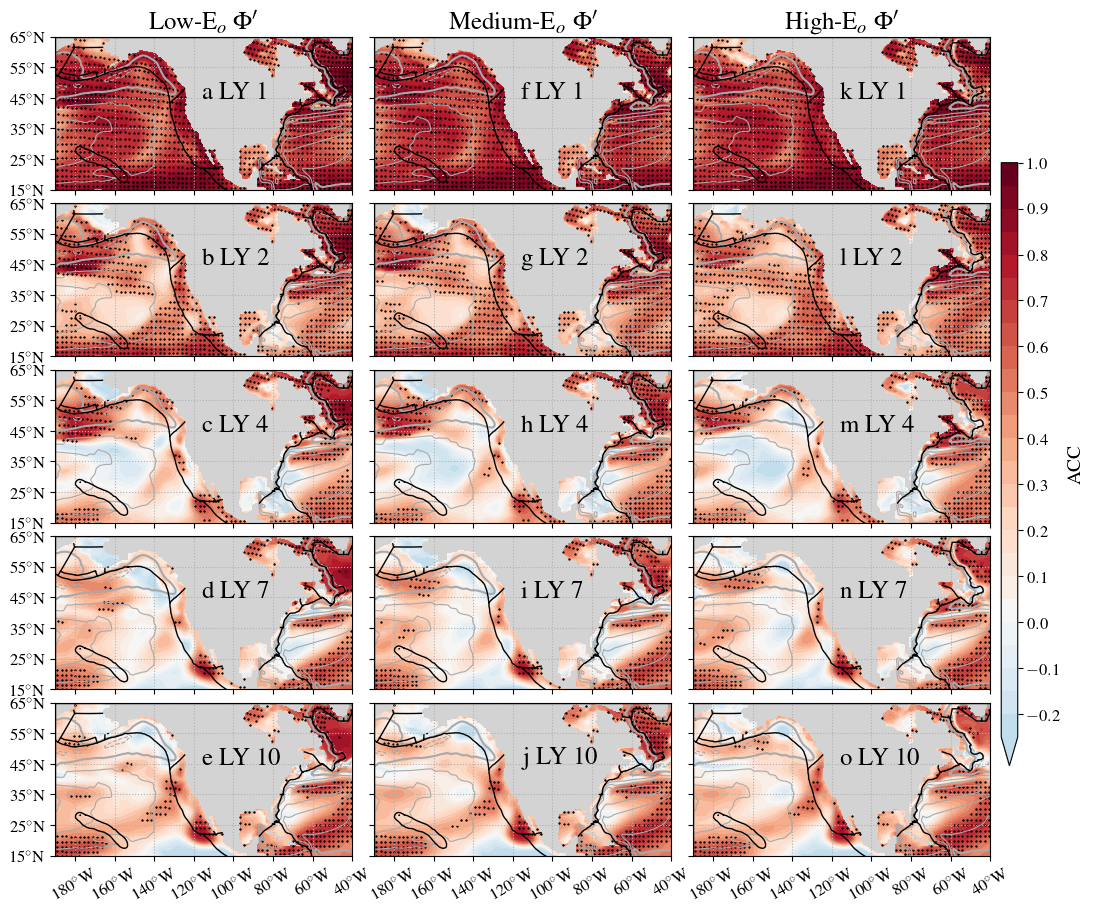

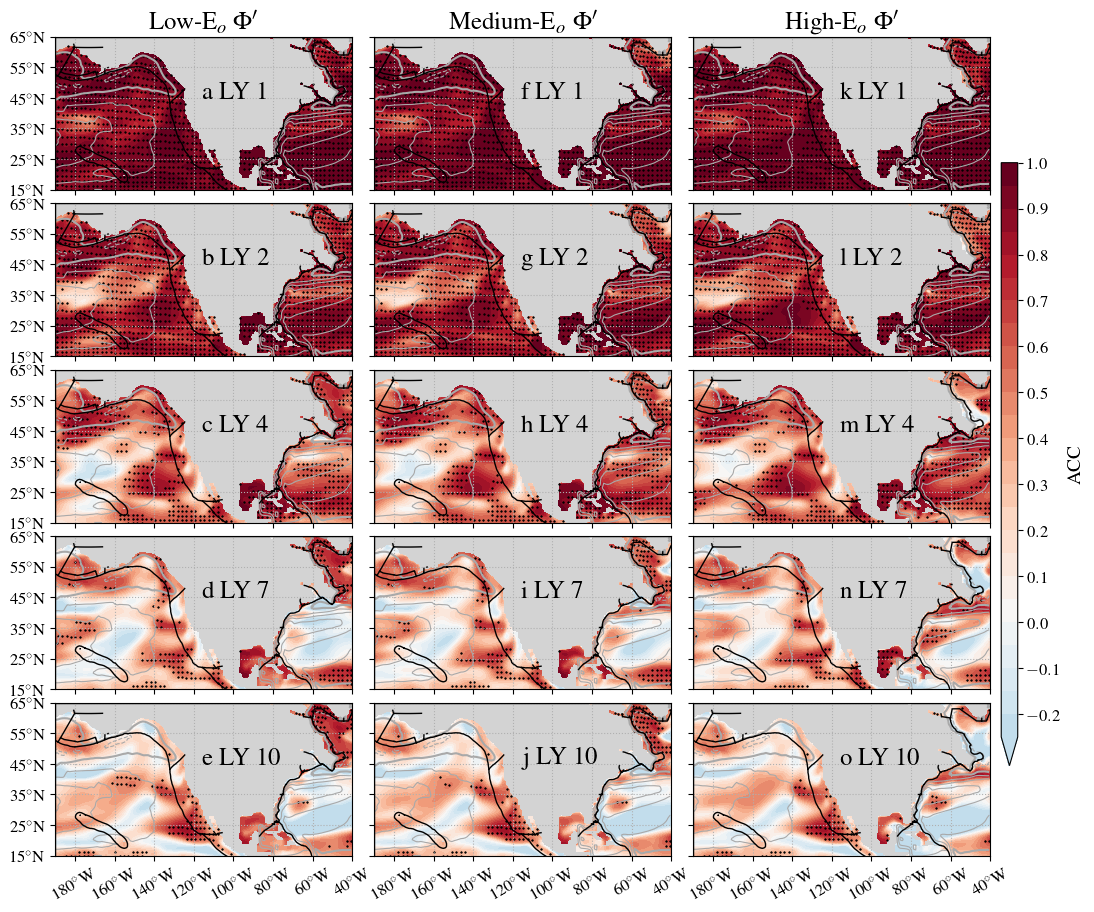

In [14]:
ngg = [['a', 'f', 'k'],\
       ['b', 'g', 'l'],\
       ['c', 'h', 'm'],\
       ['d', 'i', 'n'],\
       ['e', 'j', 'o']]
#
for layer in ['0-200m', '200-600m']:
    fig = plt.figure(figsize=[11, 9])
    gs = gridspec.GridSpec(5, 3)#, width_ratios=[1, 1, 1, 1e-2])
    # read ACC data
    # Persistence and DPLE ACC
    datadir = f'/glade/scratch/{USER}/DPLE-results'
    filename = f'{datadir}/DPLE_spatial_persistence_DPLE_ACC_{var}_{layer}_leadyear1-10_new_method2.nc' # % (datadir,var_name)
    ds_fore = xr.open_dataset(filename)
    corr_p = ds_fore['corr_p'].values
    rcri_p = ds_fore['rcri_p'].values
    corr_d = ds_fore['corr_d'].values
    rcri_d = ds_fore['rcri_d'].values
    corr13 = ds_fore['corr13'].values
    rcri13 = ds_fore['rcri13'].values
    lon = ds_fore['lon'].values
    lat = ds_fore['lat'].values
    #
    corr_p = mask_nan(corr_p);rcri_p = mask_nan(rcri_p)
    corr_d = mask_nan(corr_d);rcri_d = mask_nan(rcri_d)
    corr13 = mask_nan(corr13);rcri13 = mask_nan(rcri13)
    #
    corr_f = corr_d - corr_p
    #
    pmask = corr_p > rcri_p
    # Test ACC difference significance
    lenn = 2007+1-1954
    t_cr, p_cr = corrstats.dependent_corr(corr_p, corr_d, corr13, lenn-1, twotailed=False, method='steiger')
    #
    alpha = 0.05
    smask = p_cr <= alpha
    maskk = corr_d >= rcri_d
    maskp = corr_f > 0.
    ## plot
    lyy = np.array([0, 1, 3, 6, 9])
    for gg, ldd in zip(range(5), lyy):
        for vv, mm, tit in [[0, 0, 'Low-E$_o$'], [1, 1, 'Medium-E$_o$'], [2, 2, 'High-E$_o$']]:
            ax = fig.add_axes([0.06+mm*0.29, 0.05+(4-gg)*0.185, 0.27, 0.17])
            #
            xrr = np.arange(lon_min-10, lon_max+10)
            ax.fill_between(xrr, np.ones(len(xrr))*(lat_min-10), np.ones(len(xrr))*(lat_max+10), color='lightgray')
            for pp in range(len(lon0)):
                ax.plot(lon0[pp], lat0[pp], color='k', linewidth=1., zorder=19)
            ax.contour(lon, lat, bsf, [-10], linestyles='dashed', colors='darkgray', linewidths=.8)
            ax.contour(lon, lat, bsf, [0], linestyles='solid', colors='darkgray', linewidths=1.5)
            ax.contour(lon, lat, bsf, [10, 20, 30, 40], linestyles='solid', colors='darkgray', linewidths=.8)
            cd = ax.contourf(lon, lat, corr_d[vv, ldd], vct, shading='nearest', cmap=new_cmapt, norm=pal_normt, extend='min')
            #
            lon1 = np.ma.array(lon, mask=~maskk[vv, ldd])
            lat1 = np.ma.array(lat, mask=~maskk[vv, ldd])
            ax.scatter(lon1[::4, ::2], lat1[::4, ::2], s=5, marker='.', color='k', alpha=1, linewidth=.5)
            #
            #ax.pcolor(lon_e,lat_e,mask_bathy,shading='nearest',cmap=cm.terrain_r,vmin=.5,vmax=4,zorder=20)
            ax.text(-116, 45, '%s LY %d' % (ngg[gg][mm], ldd+1), fontsize=18, fontweight='bold', zorder=21)
            ax.set_xlim(lon_min, lon_max)
            ax.set_ylim(lat_min, lat_max)
            ax.set_xticks(np.arange(-180, -30, 20))
            ax.set_yticks(np.arange(15, 66, 10))
            #if mm == 0:
            #    ax.set_ylabel('Lead Year %d' % (ldd+1), fontsize=14, fontweight='bold')
            if gg == 0:
                ax.set_title(r"%s $\Phi'$" % tit, fontsize=18, fontweight='bold')
            #
            xtl = []
            for ii in np.arange(-180, -30, 20):
                if ii < -180:
                    ii = ii + 360
                    ff = 'E'
                elif ii >= -180:
                    ff = 'W'
                elif np.abs(ii-0) < 1e-5:
                    ff = ''
                xtl.append('%d$^\circ$%s' % (abs(ii), ff))
            ytl = []
            for jj in np.arange(15, 66, 10):
                if jj < 0:
                    ff = 'S'
                elif jj > 0:
                    ff = 'N'
                elif np.abs(jj-0) < 1e-5:
                    ff = ''
                ytl.append('%d$^\circ$%s' % (abs(jj), ff))
            if gg == 4:
                ax.set_xticklabels(xtl, fontsize=12, fontweight='bold', rotation=30)
            else:
                ax.set_xticklabels([], fontsize=12, fontweight='bold', rotation=30)
            if mm == 0:
                ax.set_yticklabels(ytl, fontsize=12, fontweight='bold')
            else:
                ax.set_yticklabels([], fontsize=12, fontweight='bold')
            ax.plot([lon_min, lon_max], [lat_max, lat_max], color='k', linewidth=1, zorder=10)
            ax.plot([lon_min, lon_min], [lat_min, lat_max], color='k', linewidth=1, zorder=10)
            ax.grid(linestyle='dotted', zorder=11)
        # colorbar
            if gg == 0 and mm == 1:
                cbaxes = fig.add_axes([0.92, 0.15, 0.015, 0.67])
                cb = plt.colorbar(cd, orientation="vertical", label='ACC', cax=cbaxes, extend='min', ticks=[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
                cb.ax.tick_params(labelsize=12)
                cb.set_label(label='ACC', fontsize=14, fontweight='bold')

    #
    output = f'/glade/scratch/{USER}/DPLE-plots'
    outfile = f'{output}/DPLE_ACC_spatial_{var}_comparison_3subsets_{layer}_leadyear1-5.png'
    plt.savefig(outfile, dpi=400)
plt.show()